In [162]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from sklearn.model_selection import train_test_split

In [163]:
torch.__version__

'2.1.0'

In [164]:
print(torch.__version__)

2.1.0


In [165]:
df = pd.read_csv("../Datasets/44K/captions.csv", delimiter=",")
df.columns = ['image', 'caption', 'caption_number', 'id']

df['caption'] = df['caption'].str.lstrip()

df.to_csv("captions.csv", index=False)


In [166]:
i = 0
for name, caption in zip(df['image'], df['caption']):
    i += 1
    if i == 20:
        break
    print(name, caption)
df.head()

15970.jpg  Checked Navy Blue Shirts for Men with Long Sleeves
53759.jpg  Solid Grey Tshirts for Men with Short Sleeves and Polo Collar
1855.jpg  Printed Grey Tshirts for Men with Short Sleeves and Round Neck
30805.jpg  Striped Green Shirts for Men with Long Sleeves
26960.jpg  Solid Purple Shirts for Women with Short Sleeves
12369.jpg  Checked Purple Shirts for Men with Long Sleeves
42419.jpg  Printed White Tops for Girls with Short Sleeves
13089.jpg  Solid Grey Sweatshirts for Men with Long Sleeves
7990.jpg  Printed Navy Blue Tshirts for Men with Short Sleeves and Round Neck
37812.jpg  Solid Navy Blue Shirts for Men with Long Sleeves
4729.jpg  Printed Green Tshirts for Boys with Short Sleeves and Round Neck
56825.jpg  Checked Brown Shirts for Men with Short Sleeves
20099.jpg  Green Kurtas for Women
3954.jpg  Printed Pink Tshirts for Women with Short Sleeves
28690.jpg  Beige Kurtas for Women
8580.jpg  Grey Waistcoat for Men
9452.jpg  Striped Red Shirts for Men with Long Sleeves
45856.jp

,image,caption,caption_number,id
0,15970.jpg,Checked Navy Blue Shirts for Men with Long Sle...,0,0
1,53759.jpg,Solid Grey Tshirts for Men with Short Sleeves ...,0,1
2,1855.jpg,Printed Grey Tshirts for Men with Short Sleeve...,0,2
3,30805.jpg,Striped Green Shirts for Men with Long Sleeves,0,3
4,26960.jpg,Solid Purple Shirts for Women with Short Sleeves,0,4


In [167]:
class CFG:
    debug = False
    image_path = "../Datasets/44k/Images"
    captions_path = "."
    batch_size = 8
    num_workers = 0
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [168]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [169]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        path = f"{CFG.image_path}/{self.image_filenames[idx]}"
        trimmed_string = path.strip()

        # image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.imread(trimmed_string)
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [170]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [171]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [172]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [173]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [174]:
# A simple Example

batch_size = 1
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1.]])


In [175]:
def make_train_valid_dfs():
    dataframe = pd.read_csv("captions.csv")
    # max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    # # max_id = dataframe["id"].max() + 1
    # image_ids = np.arange(0, max_id)
    # np.random.seed(42)
    # valid_ids = np.random.choice(
    #     image_ids, size=int(0.2 * len(image_ids)), replace=False
    # )
    # train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    # train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    # valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    train_dataframe, valid_dataframe = train_test_split(dataframe, test_size=0.2, random_state=42)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [176]:
dataframe = pd.read_csv("captions.csv")
# dataframe = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv')
dataframe.head(10)

,image,caption,caption_number,id
0,15970.jpg,Checked Navy Blue Shirts for Men with Long Sle...,0,0
1,53759.jpg,Solid Grey Tshirts for Men with Short Sleeves ...,0,1
2,1855.jpg,Printed Grey Tshirts for Men with Short Sleeve...,0,2
3,30805.jpg,Striped Green Shirts for Men with Long Sleeves,0,3
4,26960.jpg,Solid Purple Shirts for Women with Short Sleeves,0,4
5,12369.jpg,Checked Purple Shirts for Men with Long Sleeves,0,5
6,42419.jpg,Printed White Tops for Girls with Short Sleeves,0,6
7,13089.jpg,Solid Grey Sweatshirts for Men with Long Sleeves,0,7
8,7990.jpg,Printed Navy Blue Tshirts for Men with Short S...,0,8
9,37812.jpg,Solid Navy Blue Shirts for Men with Long Sleeves,0,9


In [177]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    # print('smth111')
    loss_meter = AvgMeter()
    # print('smth0')
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    # print('smth0.0')
    for batch in tqdm_object:
        # print('smth0.1')
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        # print('smth1')
        loss_meter.update(loss.item(), count)
        # print('smth2')
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.1)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        # print(f"Training . . .")
        model.train()
        # print("Training . . .2")
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        # print("Training . . .3")
        model.eval()
        # print("Training . . .4")
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        print(f"Valid Loss: {valid_loss.avg}")
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "20ephocs.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [178]:
main()
train_df, valid_df = make_train_valid_dfs()
valid_df.head()

Epoch: 1


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.8639529330201909
Saved Best Model!
Epoch: 2


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.40389662835939255
Saved Best Model!
Epoch: 3


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.45050561619836066
Epoch: 4


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.31179800833200905
Saved Best Model!
Epoch: 5


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.34519139553895734
Epoch: 6


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.3511924739175587
Epoch: 7


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.3342729435835538
Epoch: 8


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.23952617963179143
Saved Best Model!
Epoch: 9


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.20160794550338648
Saved Best Model!
Epoch: 10


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.2108389253316274
Epoch: 11


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.2100160020289529
Epoch: 12


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.2016384383984877
Epoch: 13


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.19247235273138288
Saved Best Model!
Epoch: 14


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.19774819744761965
Epoch: 15


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.20501648436225794
Epoch: 16


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.27505445337116347
Epoch: 17


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.20946802754518765
Epoch: 18


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.21045096459243284
Epoch: 19


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.18873093036183625
Saved Best Model!
Epoch: 20


  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

Valid Loss: 0.2125858458053216


,image,caption,caption_number,id
2701,15832.jpg,Pink Kurtas for Women,0,2701
3698,33968.jpg,Solid Gold Shirts for Women with Long Sleeves,0,3698
6983,23004.jpg,Solid Red Tshirts for Men with Short Sleeves a...,0,6983
14993,11767.jpg,Printed Grey Tshirts for Men with Short Sleeve...,0,14993
1766,8725.jpg,Checked Black Shirts for Men with Long Sleeves,0,1766


In [179]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [181]:
_, valid_df = make_train_valid_dfs()
model, valid_image_embeddings = get_image_embeddings(valid_df, "../Models/20ephocs.pt")

  0%|          | 0/386 [00:00<?, ?it/s]

In [185]:
def get_text_features(valid_df,):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    text_list = []
    for i in valid_df['caption']:
        encoded_query = tokenizer([i])
        # text_list.append(encoded_query)
        batch = {
            key: torch.tensor(values).to(CFG.device)
            for key, values in encoded_query.items()
        }
        with torch.no_grad():
            text_features = model.text_encoder(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            )
            text_embeddings = model.text_projection(text_features)
        
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
        text_list.append(text_embeddings_n)
    
    return torch.cat(text_list)

text_features = get_text_features(valid_df)

In [186]:
len(text_features)

3081

In [187]:
from sklearn.metrics.pairwise import cosine_similarity

text_features_cpu = text_features.cpu().numpy()
valid_image_embeddings_cpu = valid_image_embeddings.cpu().numpy()

# Compute cosine similarity
cosine_sim = cosine_similarity(text_features_cpu, valid_image_embeddings_cpu)
mean_cosine_sim = np.mean(cosine_sim)
print(f"Mean Cosine Similarity: {mean_cosine_sim:.4f}")


Mean Cosine Similarity: 0.1452


In [188]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Move tensors to CPU and convert to NumPy arrays
text_features_cpu = text_features.cpu().numpy()
valid_image_embeddings_cpu = valid_image_embeddings.cpu().numpy()

# Compute cosine similarity
cosine_sim = cosine_similarity(text_features_cpu, valid_image_embeddings_cpu)

# Create a bipartite graph
bipartite_graph = nx.Graph()

# Add nodes for text embeddings
text_nodes = [f"text_{i}" for i in range(text_features_cpu.shape[0])]
bipartite_graph.add_nodes_from(text_nodes, bipartite=0)

# Add nodes for image embeddings
image_nodes = [f"image_{i}" for i in range(valid_image_embeddings_cpu.shape[0])]
bipartite_graph.add_nodes_from(image_nodes, bipartite=1)

# Add weighted edges based on cosine similarity
for i, text_node in enumerate(text_nodes):
    for j, image_node in enumerate(image_nodes):
        weight = cosine_sim[i, j]
        bipartite_graph.add_edge(text_node, image_node, weight=weight)

# Make inferences using the bipartite graph
for text_node in text_nodes:
    # Find the most similar image node
    most_similar_image = max(bipartite_graph[text_node], key=lambda n: bipartite_graph[text_node][n]['weight'])
    print(f"Text node: {text_node}, Most similar image node: {most_similar_image}")

Text node: text_0, Most similar image node: image_1275
Text node: text_1, Most similar image node: image_1
Text node: text_2, Most similar image node: image_863
Text node: text_3, Most similar image node: image_1797
Text node: text_4, Most similar image node: image_2657
Text node: text_5, Most similar image node: image_2370
Text node: text_6, Most similar image node: image_560
Text node: text_7, Most similar image node: image_2779
Text node: text_8, Most similar image node: image_166
Text node: text_9, Most similar image node: image_2779
Text node: text_10, Most similar image node: image_2779
Text node: text_11, Most similar image node: image_1593
Text node: text_12, Most similar image node: image_2499
Text node: text_13, Most similar image node: image_560
Text node: text_14, Most similar image node: image_2183
Text node: text_15, Most similar image node: image_1708
Text node: text_16, Most similar image node: image_816
Text node: text_17, Most similar image node: image_2657
Text node:

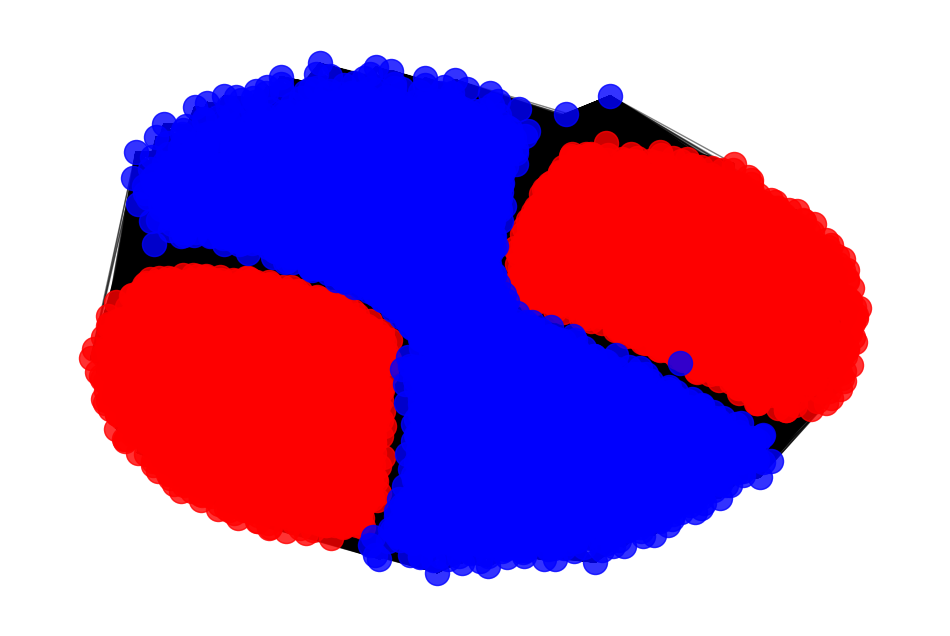

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# from sklearn.metrics.pairwise import cosine_similarity

# # Convert tensors to NumPy arrays
# text_features_cpu = text_features.cpu().numpy()
# valid_image_embeddings_cpu = valid_image_embeddings.cpu().numpy()

# # Compute cosine similarity between text and image embeddings
# cosine_sim = cosine_similarity(text_features_cpu, valid_image_embeddings_cpu)

# # Create a bipartite graph
# bipartite_graph = nx.Graph()

# # Add nodes for text embeddings
# for i, text_emb in enumerate(text_features_cpu):
#     bipartite_graph.add_node(f'text_{i}', bipartite=0)  # 0 for text nodes

# # Add nodes for image embeddings
# for j, image_emb in enumerate(valid_image_embeddings_cpu):
#     bipartite_graph.add_node(f'image_{j}', bipartite=1)  # 1 for image nodes

# # Add edges between nodes with cosine similarity as edge weight
# for i, text_emb in enumerate(text_features_cpu):
#     for j, image_emb in enumerate(valid_image_embeddings_cpu):
#         bipartite_graph.add_edge(f'text_{i}', f'image_{j}', weight=cosine_sim[i, j])

# # Draw the bipartite graph
# pos = nx.spring_layout(bipartite_graph, k=0.15, iterations=50)
# text_nodes = [node for node, value in nx.get_node_attributes(bipartite_graph, 'bipartite').items() if value == 0]
# image_nodes = [node for node, value in nx.get_node_attributes(bipartite_graph, 'bipartite').items() if value == 1]

# plt.figure(figsize=(12, 8))
# nx.draw_networkx_nodes(bipartite_graph, pos, nodelist=text_nodes, node_color='r', node_size=300, alpha=0.8)
# nx.draw_networkx_nodes(bipartite_graph, pos, nodelist=image_nodes, node_color='b', node_size=300, alpha=0.8)
# nx.draw_networkx_edges(bipartite_graph, pos, width=1.0, alpha=0.5)
# plt.axis('off')
# plt.show()

In [189]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)

    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    print(dot_similarity)

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    print(indices)
    matches = [image_filenames[idx] for idx in indices[::5]]

    print(matches)
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

This is how we use this function. Aaaannnndddd the results:

tensor([[-0.0565,  0.2128,  0.0140,  ...,  0.3088,  0.0067, -0.0648]],
       device='cuda:0')
tensor([2822, 2710, 1250,  753,  870, 1345, 2304, 1357, 1398, 2201,  305, 2603,
         523, 1003,  872, 2562, 1993,  654,  212,  539, 2718,  283, 2857,  611,
         715,  972, 3013, 1367, 1603,  555,  603,  186, 2677, 1438, 1920, 2826,
         385,  812,  316,  494,  984,  593, 1841, 2149, 2108], device='cuda:0')
['43629.jpg ', '43505.jpg ', '2344.jpg ', '34209.jpg ', '42103.jpg ', '18178.jpg ', '18762.jpg ', '53773.jpg ', '10486.jpg ']


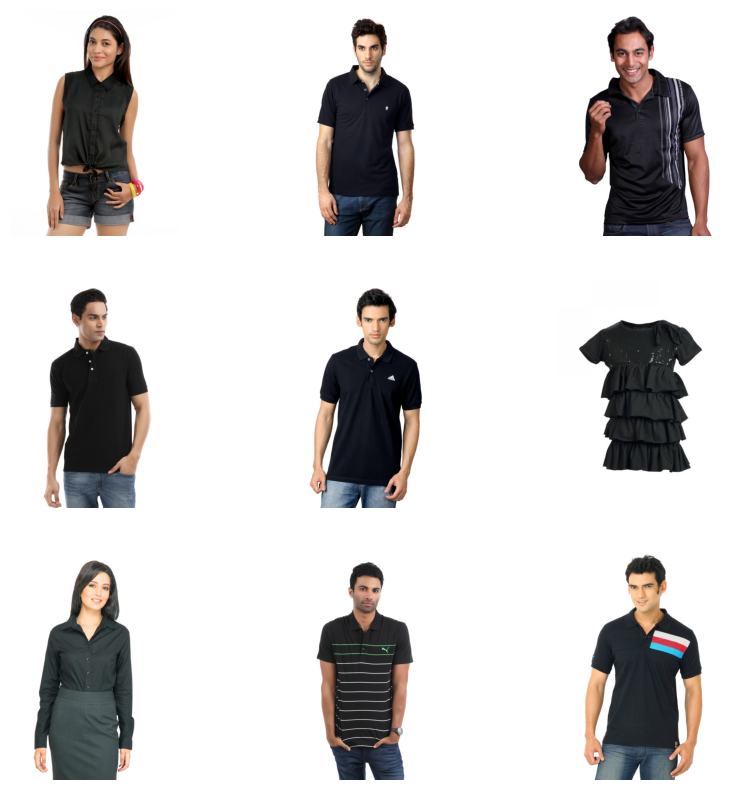

In [198]:
find_matches(model, 
             valid_image_embeddings,
             query="Solid Black T-Shirt with short sleeves",
             image_filenames=valid_df['image'].values,
             n=9)

In [ ]:
import pickle
# dataframe = pd.read_csv("captions.csv")
model, all_image_embeddings = get_image_embeddings(dataframe, "../Models/20ephocs.pt")
def save_embeddings(all_image_embeddings, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(all_image_embeddings, f)

In [195]:

# Save the valid image embeddings
save_embeddings(valid_image_embeddings, '../pikels/20ephochs_valid_image_embeddings.pkl')

In [196]:
def save_embeddingss(all_image_embeddings, image_filenames, file_path):
    embeddings_dict = {str(filename): embedding.cpu().numpy()
                       for filename, embedding in zip(image_filenames, all_image_embeddings)}

    with open(file_path, 'wb') as f:
        pickle.dump(embeddings_dict, f)

In [197]:
# model, all_image_embeddings = get_image_embeddings(dataframe, "../Models/20ephocs.pt")
image_filenames = dataframe['image'].values

save_embeddingss(all_image_embeddings, image_filenames, '../pikels/embeddings_dict.pkl')

In [202]:
class MatchFinder:
    def __init__(self, model_path, embeddings_path):
        self.model = CLIPModel().to(CFG.device)
        self.model.load_state_dict(torch.load(model_path, map_location=CFG.device))
        self.model.eval()

        with open(embeddings_path, 'rb') as f:
            self.valid_image_embeddings = pickle.load(f)

        self.dataframe = pd.read_csv("captions.csv")

    def find_matches(self, query, n=9):
        tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
        encoded_query = tokenizer([query])
        batch = {
            key: torch.tensor(values).to(CFG.device)
            for key, values in encoded_query.items()
        }
        with torch.no_grad():
            text_features = self.model.text_encoder(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            )
            text_embeddings = self.model.text_projection(text_features)

        image_embeddings_n = F.normalize(self.valid_image_embeddings, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

        dot_similarity = text_embeddings_n @ image_embeddings_n.T
        print(dot_similarity)

        values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
        print(indices)
        matches = [self.dataframe['image'].values[idx] for idx in indices[::5]]

        print(matches)
        return matches

In [203]:
match_finder = MatchFinder(
    model_path="../Models/20ephocs.pt",
    embeddings_path="../pikels/20ephochs_all_image_embeddings.pkl",
)

In [206]:
matches = match_finder.find_matches(query="Solid Black T-Shirt with short sleeves")
matches

tensor([[ 0.1617,  0.2609, -0.0102,  ..., -0.0172, -0.0760, -0.1356]],
       device='cuda:0')
tensor([ 1437, 12498,  6762,  5796,  5818,  3594,  8680, 10279, 13058, 11037,
         4158,  6808, 15132,  3454,  3253,  3653,   440,  6323, 11283, 12044,
        14758, 11075,  6318,  4365,  3996,  5445,  4136,  9817,  8925, 12948,
         2599,  9481, 11088,  7531, 12784,  8827,   380,  6917,   126,  2461,
        12334,   363, 13244, 12635,  6570], device='cuda:0')
['59838.jpg ', '18522.jpg ', '3009.jpg ', '43481.jpg ', '2050.jpg ', '13711.jpg ', '2133.jpg ', '16908.jpg ', '17914.jpg ']


['59838.jpg ',
 '18522.jpg ',
 '3009.jpg ',
 '43481.jpg ',
 '2050.jpg ',
 '13711.jpg ',
 '2133.jpg ',
 '16908.jpg ',
 '17914.jpg ']

In [207]:
import numpy as np

def exponential_kernel(X, Y=None, gamma=0.1):
    """
    Computes the exponential kernel between two matrices X and Y.
    
    Parameters:
    X (numpy.ndarray): First input matrix of shape (n_samples_X, n_features).
    Y (numpy.ndarray, optional): Second input matrix of shape (n_samples_Y, n_features).
        If None, Y is set to X.
    gamma (float, optional): Kernel coefficient, default is 0.1.
    
    Returns:
    numpy.ndarray: Kernel matrix of shape (n_samples_X, n_samples_Y).
    """
    if Y is None:
        Y = X
    
    X_squared = np.sum(X**2, axis=1, keepdims=True)
    Y_squared = np.sum(Y**2, axis=1, keepdims=True).T
    
    squared_distances = X_squared + Y_squared - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * squared_distances)

# Compute the exponential kernel between text features and image embeddings
text_image_similarity = exponential_kernel(text_features_cpu, valid_image_embeddings_cpu, gamma=0.1)

In [208]:
text_image_similarity

array([[0.02360235, 0.01403402, 0.01140927, ..., 0.01324699, 0.03339376,
        0.00512621],
       [0.01589604, 0.0221774 , 0.0093542 , ..., 0.01386129, 0.02412289,
        0.00550133],
       [0.01547086, 0.01358776, 0.01734579, ..., 0.01339817, 0.0245984 ,
        0.00491895],
       ...,
       [0.01676387, 0.01298177, 0.00882597, ..., 0.0179694 , 0.02602307,
        0.00502319],
       [0.02360235, 0.01403402, 0.01140927, ..., 0.01324699, 0.03339376,
        0.00512621],
       [0.01449048, 0.01279543, 0.00797269, ..., 0.01158855, 0.02154978,
        0.008714  ]], dtype=float32)

In [209]:
mean_similarity = np.mean(text_image_similarity)
print(f"The mean similarity between text features and image embeddings is: {mean_similarity}")

The mean similarity between text features and image embeddings is: 0.015416127629578114


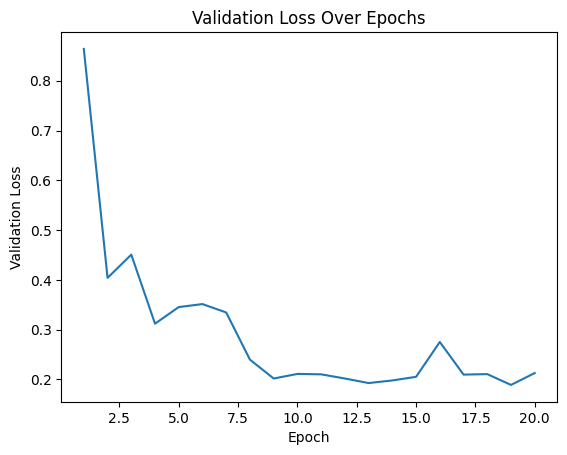

In [1]:
import matplotlib.pyplot as plt

# Fill the losses and epochs lists manually
losses = [0.8639529330201909, 0.40389662835939255, 0.45050561619836066, 0.31179800833200905,
          0.34519139553895734, 0.3511924739175587, 0.3342729435835538, 0.23952617963179143,
          0.20160794550338648, 0.2108389253316274, 0.2100160020289529, 0.2016384383984877,
          0.19247235273138288, 0.19774819744761965, 0.20501648436225794, 0.27505445337116347,
          0.20946802754518765, 0.21045096459243284, 0.18873093036183625, 0.2125858458053216]

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Create a line plot
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.show()